In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import  classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier


%matplotlib inline 

In [2]:
import importlib
import ids_common
importlib.reload(ids_common)

<module 'ids_common' from 'd:\\stuff\\univ\\ids\\ids_common.py'>

In [68]:
df = pd.read_csv('./dataset/Edge-IIoTset-dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv', low_memory=False)
ids_common.cleanup_dataset_ferrag(df)

mixed_zeros = ['mqtt.topic', 
                'mqtt.conack.flags', 
                'mqtt.protoname',
                'dns.qry.name.len',
                'http.request.method',
                'http.referer', 
                'http.request.version']

for col in mixed_zeros:
    df.loc[(df[col] == '0') | (df[col] == '0x00000000'), col] = '0.0'

ids_common.drop_na_dups(df, verbose=True)
df['Attack_type'] = df['Attack_type'].astype('category')

object_col = [col for col in df.columns if df[col].dtype == 'object']
for col in object_col:
    ids_common.encode_text_dummy(df, col)

df.info()

Before: dropna: NA: 0, DUPS: 309530
After: dropna: NA: 0, DUPS: 0
<class 'pandas.core.frame.DataFrame'>
Index: 1909671 entries, 0 to 2219193
Data columns (total 89 columns):
 #   Column                                                                                                Dtype   
---  ------                                                                                                -----   
 0   arp.opcode                                                                                            float64 
 1   arp.hw.size                                                                                           float64 
 2   icmp.checksum                                                                                         float64 
 3   icmp.seq_le                                                                                           float64 
 4   icmp.unused                                                                                           float64 
 5   http.cont

In [84]:
SEED = random.randint(0, 42424242)
SEED = 42
print(f'SEED = {SEED}')

#TODO: rename to detection_class and classification_class
target_label_2_class = 'Attack_label' # 0 indicates normal and 1 indicates attacks
target_label_15_class = 'Attack_type'

def ds_detection_split(dataset):
    y = dataset[target_label_2_class]
    X = dataset.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)
    return train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

def ds_split(dataset):
    return train_test_split(dataset, test_size=0.2, random_state=SEED, stratify=dataset[target_label_15_class])

def ds_classification_split(dataset):
    loc_df = dataset.drop(dataset[dataset[target_label_2_class] == 0].index, inplace=False)
    y = loc_df[target_label_15_class]
    X = loc_df.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)
    return train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

SEED = 42


In [85]:
df_train_global, df_test_global = ds_split(df)
print(f'df_train_global={df_train_global.shape}')
print(f'df_test_global={df_test_global.shape}')

df_train_global=(1527736, 89)
df_test_global=(381935, 89)


In [86]:
X_train_detection, X_test_detection, y_train_detection, y_test_detection = ds_detection_split(df_train_global)
print(f'X_train_detection={X_train_detection.shape} y_train_detection={y_train_detection.shape}')
print(f'X_test_detection={X_test_detection.shape}   y_test_detection={y_test_detection.shape}')

X_train_detection=(1222188, 87) y_train_detection=(1222188,)
X_test_detection=(305548, 87)   y_test_detection=(305548,)


In [87]:
X_train_classification, X_test_classification, y_train_classification, y_test_classification = ds_classification_split(df_train_global)
print(f'X_train_classification={X_train_classification.shape} y_train_classification={y_train_classification.shape}')
print(f'X_test_classification={X_test_classification.shape}   y_test_classification={y_test_classification.shape}')

X_train_classification=(349230, 87) y_train_classification=(349230,)
X_test_classification=(87308, 87)   y_test_classification=(87308,)


In [88]:
def report(y_train, y_train_predict, y_test, y_test_predict):

    print('TRAIN:')
    print(classification_report(y_train, y_train_predict))

    print('TEST:')
    print(classification_report(y_test, y_test_predict))

def plot_cm(y_true, y_predict):
    title='Normalized confusion matrix'

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_predict,
        # display_labels=Attack_type_classes,
        cmap=plt.cm.Blues,
        normalize='true',
        values_format='.2f'
    )
    disp.ax_.set_title(title)
    disp.figure_.set_size_inches(8, 8, forward=True)
    plt.xticks(rotation=90)
    plt.show()

TRAIN:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    872958
           1       1.00      0.98      0.99    349230

    accuracy                           0.99   1222188
   macro avg       0.99      0.99      0.99   1222188
weighted avg       0.99      0.99      0.99   1222188

TEST:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    218240
           1       0.92      0.91      0.92     87308

    accuracy                           0.95    305548
   macro avg       0.94      0.94      0.94    305548
weighted avg       0.95      0.95      0.95    305548



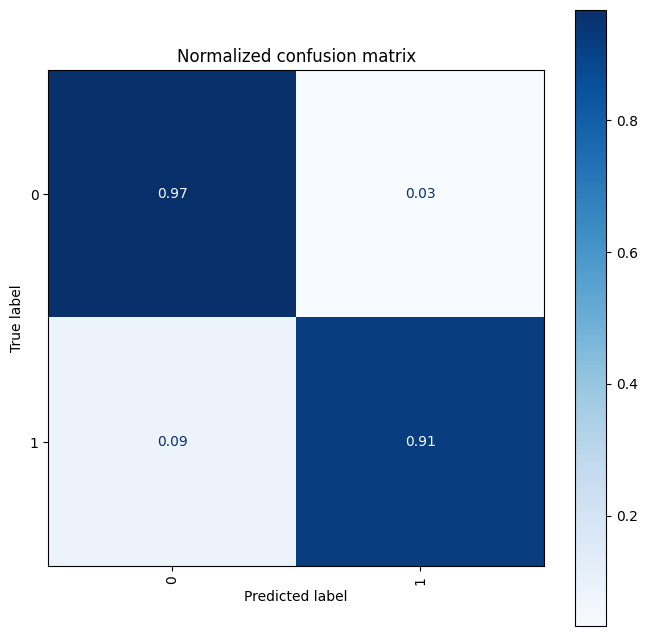

In [89]:
detector = DecisionTreeClassifier(random_state=SEED)


detector.fit(X_train_detection, y_train_detection)
y_train_detection_predict = detector.predict(X_train_detection)
y_test_detection_predict = detector.predict(X_test_detection)
report(y_train_detection, 
       y_train_detection_predict, 
       y_test_detection,
       y_test_detection_predict)

plot_cm(y_test_detection, y_test_detection_predict)


TRAIN:
                       precision    recall  f1-score   support

             Backdoor       0.99      1.00      1.00     15377
            DDoS_HTTP       0.96      1.00      0.98     31068
            DDoS_ICMP       1.00      1.00      1.00     43481
             DDoS_TCP       1.00      1.00      1.00     32040
             DDoS_UDP       1.00      1.00      1.00     77802
       Fingerprinting       0.97      0.98      0.98       545
                 MITM       1.00      1.00      1.00       229
             Password       0.99      0.99      0.99     31957
        Port_Scanning       1.00      1.00      1.00     12785
           Ransomware       0.99      0.99      0.99      6201
        SQL_injection       0.99      0.99      0.99     32529
            Uploading       1.00      0.96      0.98     23557
Vulnerability_scanner       1.00      1.00      1.00     32017
                  XSS       1.00      0.98      0.99      9642

             accuracy                         

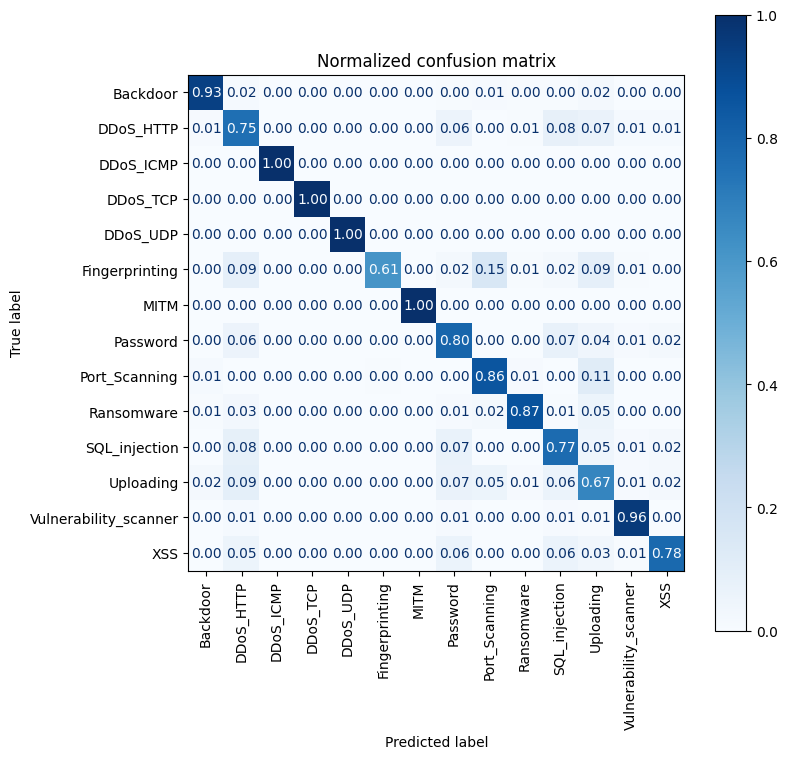

In [90]:
classifier = DecisionTreeClassifier(random_state=SEED)
classifier.fit(X_train_classification, y_train_classification)
y_train_classification_predict = classifier.predict(X_train_classification)
y_test_classification_predict = classifier.predict(X_test_classification)
report(y_train_classification, 
       y_train_classification_predict, 
       y_test_classification,
       y_test_classification_predict)

plot_cm(y_test_classification, y_test_classification_predict)

DETECTION:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    272800
           1       0.91      0.91      0.91    109135

    accuracy                           0.95    381935
   macro avg       0.94      0.94      0.94    381935
weighted avg       0.95      0.95      0.95    381935



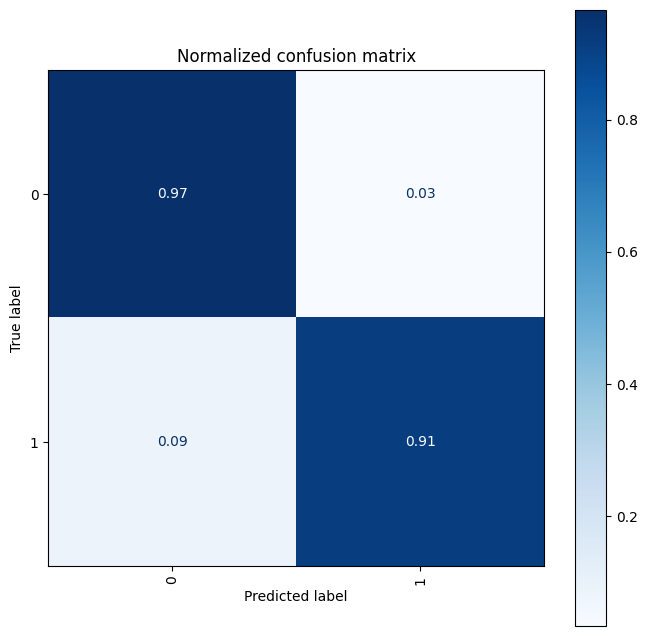

In [92]:
# df_train_global, df_test_global = ds_split(df)

y_global_detection = df_test_global[target_label_2_class]
X_global_detection = df_test_global.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)

y_global_detection_predict = detector.predict(X_global_detection)
print('DETECTION:')
print(classification_report(y_global_detection, y_global_detection_predict))
plot_cm(y_global_detection, y_global_detection_predict)




# y_classification_global = df_test_global[target_label_15_class]


# y_train_detection_predict = detector.predict(X_train_detection)
# y_test_detection_predict = detector.predict(X_test_detection)
# report(y_train_detection, 
#        y_train_detection_predict, 
#        y_test_detection,
#        y_test_detection_predict)


CLASSIFICATION:


c:\Users\pro17\anaconda3\envs\ids\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pro17\anaconda3\envs\ids\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pro17\anaconda3\envs\ids\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                       precision    recall  f1-score   support

             Backdoor       0.93      0.96      0.94      4658
            DDoS_HTTP       0.67      0.88      0.76      7462
            DDoS_ICMP       1.00      1.00      1.00     13588
             DDoS_TCP       1.00      1.00      1.00     10012
             DDoS_UDP       1.00      1.00      1.00     24314
       Fingerprinting       0.71      0.74      0.73       155
                 MITM       1.00      1.00      1.00        72
               Normal       0.00      0.00      0.00      9281
             Password       0.74      0.95      0.83      7864
        Port_Scanning       0.86      0.86      0.86      3995
           Ransomware       0.89      0.92      0.90      1854
        SQL_injection       0.72      0.91      0.80      8053
            Uploading       0.65      0.83      0.73      5599
Vulnerability_scanner       0.96      0.98      0.97      9734
                  XSS       0.76      0.94      0.84  

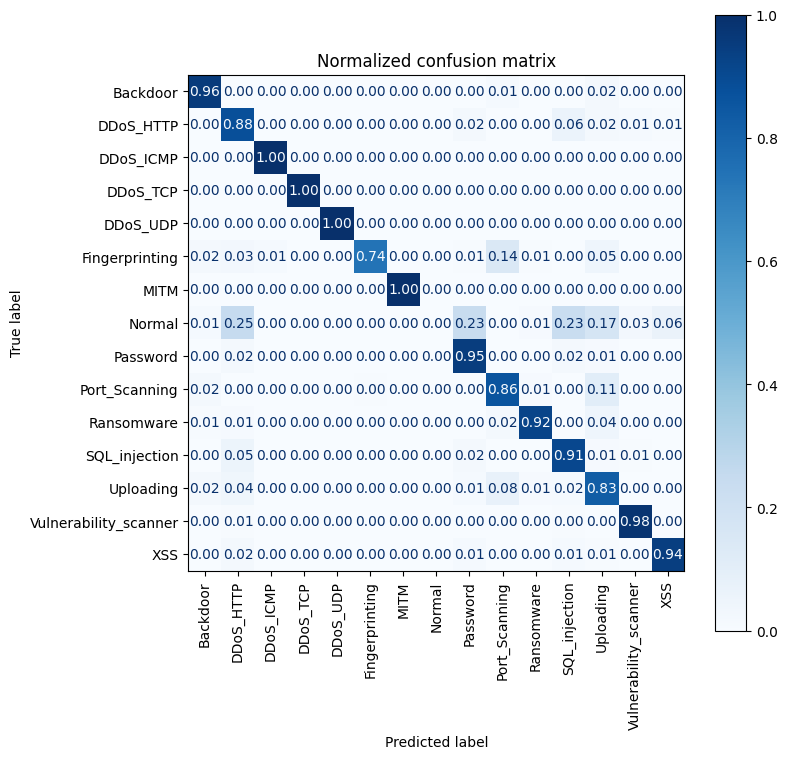

In [105]:

# np.unique(y_global_detection_predict, return_counts=True)
# (array([0, 1], dtype=int64), array([272875, 109060], dtype=int64))

ds_classification = df_test_global[y_global_detection_predict==1]

y_global_classification = ds_classification[target_label_15_class]
X_global_classification = ds_classification.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)

y_global_classification_predict = classifier.predict(X_global_classification)

print('CLASSIFICATION:')
print(classification_report(y_global_classification, y_global_classification_predict))
plot_cm(y_global_classification, y_global_classification_predict)

# pd.Series([True, False, True, True, False, False, False, True]).values


In [ ]:
detected_attack_type = []

y_global_label = df_test_global[target_label_2_class]
y_global_type = df_test_global[target_label_15_class]
X_global = df_test_global.drop([target_label_2_class, target_label_15_class], axis=1, inplace=False)

c = 0
for i in df_test_global.index:
    
   
    xx = X_global.loc[i].to_numpy().reshape(1, -1)
    y_detected = detector.predict(xx)[0]

    traffic_type = None
     
    if not y_detected:
        traffic_type = 'Normal'
    else:
        y_class_predicted = classifier.predict(xx)[0]
        traffic_type = y_class_predicted


    detected_attack_type.append(traffic_type)
    

    # print(traffic_type, y_global_label.loc[i], y_global_type.loc[i])
    
    # c += 1
    # if c > 10:
    #     break

print('ALL:')
print(classification_report(y_global_type, detected_attack_type))
plot_cm(y_global_type, detected_attack_type)

# df2__ = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]), columns=['a', 'b', 'c'])

# x2 = df2__.drop('c', axis=1, inplace=False)
# y2 = df2__['c']

# for i in df2__.index:
#     xx = x2.loc[i]
#     yy = y2.loc[i]
#     print(xx, yy)

# # print(x2)
# # print(y2)

In [ ]:
for col in df.columns:
    if df[col].dtype == 'object':
        uniq = df[col].unique()
        num_uniq = len(uniq)
        print(col, df[col].dtype, num_uniq)

        print(df.groupby('Attack_label')[col].value_counts())
        print('-'*80)

   


In [ ]:
sel_col = [col for col in df.columns if df[col].dtype == 'object']
print(sel_col)
df_sel = df[sel_col]

for col in df_sel.columns:
    ids_common.encode_text_dummy(df_sel, col)





In [29]:
df['Attack_label'].value_counts()

Attack_label
0    1615643
1     603558
Name: count, dtype: int64

In [44]:
from sklearn.feature_selection import chi2


chi2_stats, p_values = chi2(df_sel, df['Attack_label'])


for col, chi, p in zip(df_sel.columns, chi2_stats, p_values):
    print(f'{col:84} {chi:12.2f} {p:12.2f}')






http.request.method-0.0                                                                   9378.67         0.00
http.request.method-GET                                                                 654579.71         0.00
http.request.method-OPTIONS                                                                259.72         0.00
http.request.method-POST                                                                 42216.79         0.00
http.request.method-PROPFIND                                                               173.15         0.00
http.request.method-PUT                                                                     86.57         0.00
http.request.method-SEARCH                                                                  86.57         0.00
http.request.method-TRACE                                                                52468.68         0.00
http.referer-() { _; } >_[$($())] { echo 93e4r0-CVE-2014-6278: true; echo;echo; }         8008.02         0.00
h

In [ ]:
for col in ids_common.to_drop_1_unique:
    uniques = df[col].unique()
    num_uniques = len(uniques)
    stats.append((col, df[col].dtype, num_uniques))

num_rows = df.shape[0]
for i, sts in enumerate(sorted(stats, key=lambda x: x[2])):
    col, val_type, num_uniq = sts
    dropped = '------------'
    print(f'{i:<4}{col:<32}{str(val_type):<12}{num_uniq:>6} [{dropped:^24}]')

    if num_uniq < 10:
        # val_count = df[c].value_counts().sort_values()
        val_count = df.groupby('Attack_label')[col].value_counts().div(num_rows)
        print(val_count)
    print('-'*80)